In [1]:
import os, shutil
import time, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import h5py

from sklearn.model_selection import KFold, GroupShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn import svm
from sklearn import metrics 

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

print('Tensorflow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [2]:
data_dir = 'C:/Users/User/Desktop/mel-spektrogramy'
model_dir = 'C:/Users/User/Desktop/Models'
train_data = 'trenowanie mel-spektrogramy.h5'
validation_data = 'walidacja mel-spektrogramy.h5'
test_data = 'testowanie mel-spektrogramy.h5'
model_fname = 'model_v1.h5'

n_scenes = 2
print('Done')

Done


Spectrogram size: (150, 174)
X_train.shape = (5250, 150, 174, 3)
X_validation.shape = (1050, 150, 174, 3)
X_test.shape = (450, 150, 174, 3)


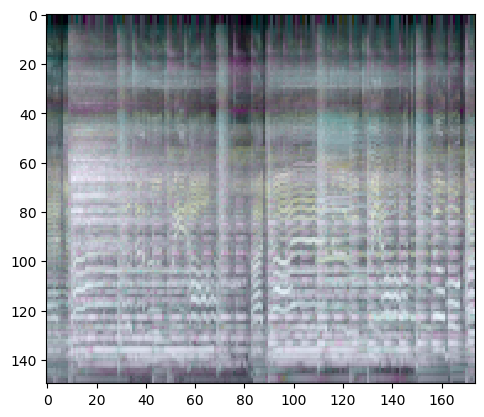

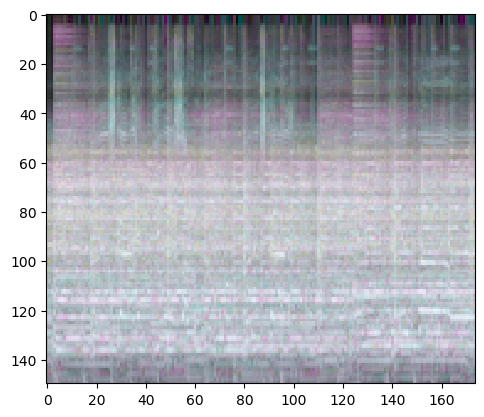

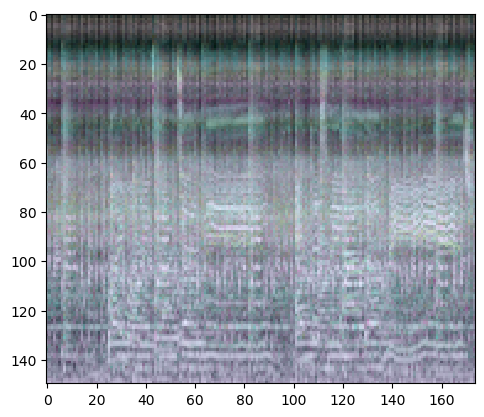

In [3]:
data_train_h5 = h5py.File(os.path.join(data_dir, train_data))
data_validation_h5 = h5py.File(os.path.join(data_dir, validation_data))
data_test_h5 = h5py.File(os.path.join(data_dir, test_data))

X_train = data_train_h5['spectrograms'][:].T
X_validation = data_validation_h5['spectrograms'][:].T
X_test = data_test_h5['spectrograms'][:].T


y_train = data_train_h5['labels'][:].T.astype(int)
y_validation = data_validation_h5['labels'][:].T.astype(int)
y_test = data_test_h5['labels'][:].T.astype(int)


print('Spectrogram size:',X_train[0,:,:,0].shape)
print('X_train.shape =',X_train.shape)
print('X_validation.shape =',X_validation.shape)
print('X_test.shape =',X_test.shape)

plt.style.use('default')
for ii in range(3):
    random_number = np.random.randint(X_train.shape[0])
    plt.imshow(X_train[random_number])
    plt.show() 

In [4]:
#Standaryzacja Danych

mean_value = np.mean(X_train)
std_value = np.std(X_train)
X_train = (X_train - mean_value)/std_value
X_validation = (X_validation - mean_value)/std_value
X_test = (X_test - mean_value)/std_value

print('Done')

Done


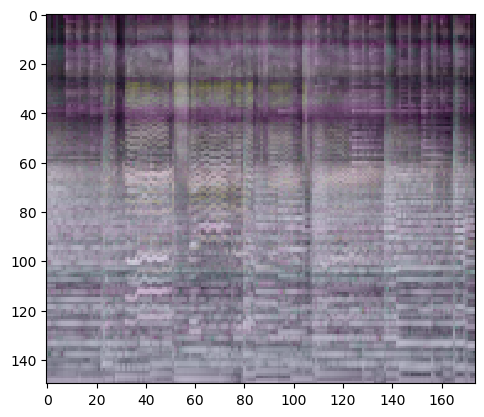

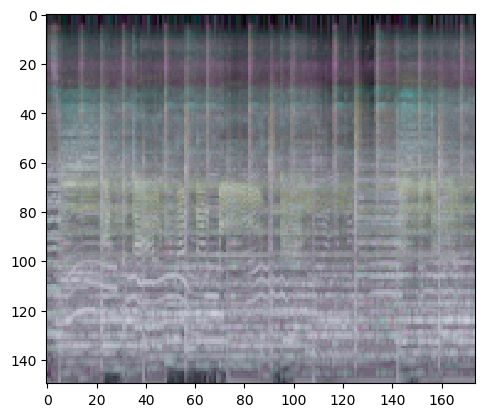

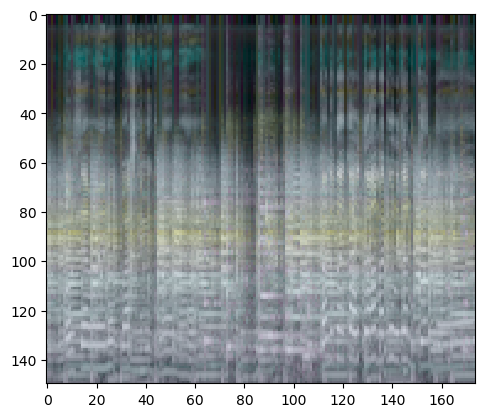

Done


In [5]:
# Show sample spectrograms
plt.style.use('default')
abs_peak_value = np.max(abs(X_train))
for ii in range(3):
    random_number = np.random.randint(X_train.shape[0])
    random_image = 0.5 + 0.499*X_train[random_number]/abs_peak_value
    plt.imshow(random_image)
    plt.show()

# One-Hot-Encoder
train_labels = to_categorical(y_train)
validation_labels = to_categorical(y_validation)
test_labels = to_categorical(y_test)

print('Done')

In [6]:
dropout = 0.5

model_v1 = models.Sequential()
model_v1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 174, 3)))
model_v1.add(layers.BatchNormalization(axis=-1))
model_v1.add(layers.MaxPooling2D((2, 2)))
model_v1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_v1.add(layers.BatchNormalization(axis=-1))
model_v1.add(layers.MaxPooling2D((2, 2)))
model_v1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_v1.add(layers.BatchNormalization(axis=-1))
model_v1.add(layers.MaxPooling2D((2, 2)))
model_v1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_v1.add(layers.BatchNormalization(axis=-1))
model_v1.add(layers.MaxPooling2D((2, 2)))
model_v1.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_v1.add(layers.Flatten())
model_v1.add(layers.Dropout(dropout))
model_v1.add(layers.Dense(512, activation='relu'))
model_v1.add(layers.Dropout(dropout))
model_v1.add(layers.Dense(16, activation='relu'))
model_v1.add(layers.Dropout(dropout))
model_v1.add(layers.Dense(2, activation='softmax'))

model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 172, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 172, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 86, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 84, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 84, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 40, 128)       7

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_v1.compile(optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'])

model_v1.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.0002,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [8]:
acc = []
val_acc = []
loss = []
val_loss = []

print('Done')

Done


In [9]:
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)
    
time.sleep(2)
if not os.path.exists(model_dir ):
    os.mkdir(model_dir)  

In [10]:
early_stopping = EarlyStopping(monitor='val_accuracy',                                     
                               patience=10,                                           
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_dir, 'model-epoch-{epoch:03d}-{val_accuracy:.3f}.hdf5'), 
                                   monitor='val_accuracy', 
                                   save_best_only=True,  
                                   verbose=0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',     
                                         factor=0.5,
                                         patience=7, 
                                         min_lr=2e-5, 
                                         verbose=1)

In [11]:
start_time = time.time()

history_v1 = model_v1.fit(x=X_train, y=train_labels, 
          batch_size=64, 
          epochs=100,
          verbose=1, 
          validation_data=(X_validation, validation_labels), 
          shuffle=True,
          callbacks=[early_stopping, model_checkpoint],  
          validation_freq=1)

acc.extend(history_v1.history['accuracy'])
loss.extend(history_v1.history['loss'])

val_acc.extend(history_v1.history['val_accuracy'])
val_loss.extend(history_v1.history['val_loss'])

print('\nTime elapsed (hh:mm:ss): ', datetime.timedelta(seconds=(time.time()-start_time)))

Train on 5250 samples, validate on 1050 samples
Epoch 1/100
5250/5250 [==============================] - 17s 3ms/sample - loss: 0.7600 - accuracy: 0.5125 - val_loss: 0.6924 - val_accuracy: 0.5238
Epoch 2/100
5250/5250 [==============================] - 12s 2ms/sample - loss: 0.5595 - accuracy: 0.6773 - val_loss: 0.4813 - val_accuracy: 0.8600
Epoch 3/100
5250/5250 [==============================] - 12s 2ms/sample - loss: 0.2693 - accuracy: 0.9046 - val_loss: 0.1364 - val_accuracy: 0.9562
Epoch 4/100
5250/5250 [==============================] - 11s 2ms/sample - loss: 0.1472 - accuracy: 0.9598 - val_loss: 0.1122 - val_accuracy: 0.9495
Epoch 5/100
5250/5250 [==============================] - 12s 2ms/sample - loss: 0.0797 - accuracy: 0.9813 - val_loss: 0.0245 - val_accuracy: 0.9905
Epoch 6/100
5250/5250 [==============================] - 12s 2ms/sample - loss: 0.0545 - accuracy: 0.9840 - val_loss: 0.0127 - val_accuracy: 0.9943
Epoch 7/100
5250/5250 [==============================] - 11s 2ms

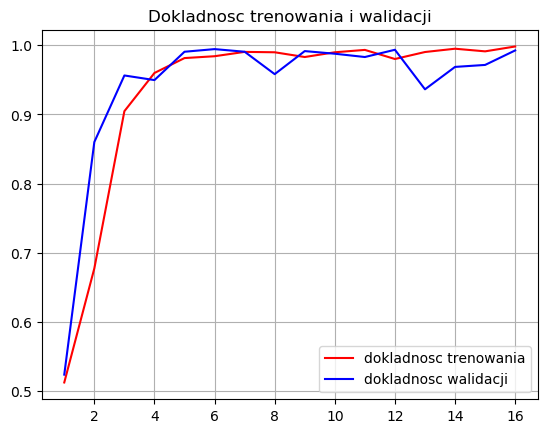

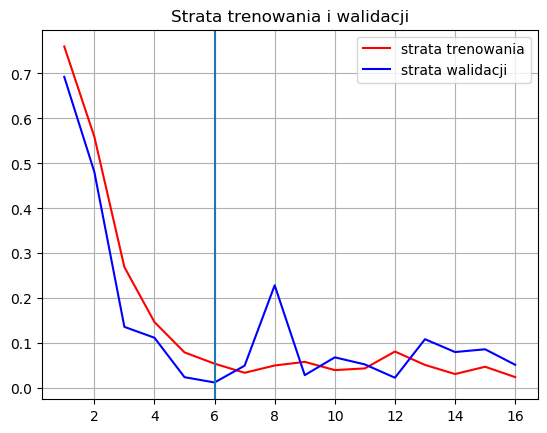

In [12]:
def smooth_curve(points, smoothing_factor=0.0):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * smoothing_factor + point * (1 - smoothing_factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

epochs = range(1,len(acc)+1)
plt.style.use('default')
plt.plot(epochs, smooth_curve(acc), 'r', label='dokladnosc trenowania')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
#plt.axvline(x=np.argmax(val_acc)+1)
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'r', label='strata trenowania')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.axvline(x=np.argmin(val_loss)+1)
plt.grid()
plt.legend()


In [13]:
model_fnames = os.listdir(model_dir)
model_v1 = models.load_model(os.path.join(model_dir, model_fnames[-1]))

In [14]:
[test_loss, test_acc] = model_v1.evaluate(x=X_test, y=test_labels, batch_size=64, verbose=0)

print('Test acc:', test_acc)

Test acc: 0.8333333


In [15]:
y_test_pred_probs = model_v1.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

print('\nTest metrics:')
print('Accuracy:', round(metrics.accuracy_score(y_test,y_test_pred),3))
print(metrics.classification_report(y_test,y_test_pred))


Test metrics:
Accuracy: 0.833
              precision    recall  f1-score   support

           0       1.00      0.67      0.80       225
           1       0.75      1.00      0.86       225

    accuracy                           0.83       450
   macro avg       0.88      0.83      0.83       450
weighted avg       0.88      0.83      0.83       450



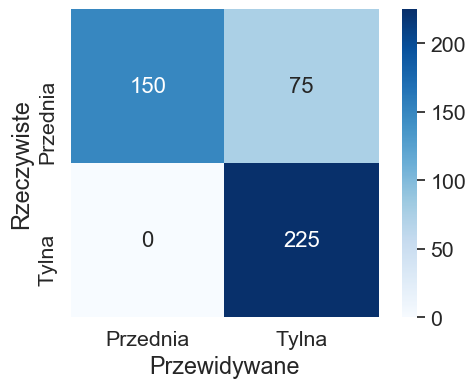

In [16]:
labels = list([0, 1])
labels

cm = metrics.confusion_matrix(y_test, y_test_pred, labels=labels)

df_cm = pd.DataFrame(cm, columns=['Przednia','Tylna'], index =['Przednia','Tylna'])
df_cm.index.name = 'Rzeczywiste'
df_cm.columns.name = 'Przewidywane'
plt.figure(figsize = (6,4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g', square=True)
plt.ylim(2, 0) # To prevent axis clipping effect
plt.show()